# Apollo3 Audio Preprocessor

This notebook simulates the algo of audio preprocessing in apollo3.


In [20]:
import serial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib notebook
from scipy import signal
import matplotlib.pyplot as plt

# import local developed functions
from stft import stft
from scnr import scnr

## Open Serial Port

Run this cell once (per kernel)

In [3]:
port = '/dev/tty.usbmodem0004830868271'

serialPort = serial.Serial(port = port, baudrate=115200,
                           bytesize=8, timeout=2, stopbits=serial.STOPBITS_ONE)

Get raw PCM samples from Apollo 3

In [58]:
serialString = ""     # Used to hold data coming over UART
line = ""             # Used to hold decoded Ascii

captureEnabled=False  # Set True when first sample comes in, and False after last sample 

samples = np.array([])

while(1):

    # Wait until there is data waiting in the serial buffer
    if(serialPort.in_waiting > 0):

        # Read data out of the buffer until a carraige return / new line is found
        serialString = serialPort.readline()

        # Decode Ascii
        line = serialString.decode('Ascii')
        
        # remove newlines
        line = line.rstrip()
        

        if 'The end of data transfer...' in line:
            captureEnabled = False;
            break;
        
        if captureEnabled:
            samples = np.append(samples, np.array(line.split(' ')).astype(np.int))
            
        else:
            # Print the contents of the serial data (when capture is disabled)
            print(line)
            
        if 'Audio recording is terminated and data starts to upload:' in line:
            captureEnabled = True;
  

        # Tell the device connected over the serial port that we recevied the data!
        # The b at the beginning is used to indicate bytes!
        #serialPort.write(b"Thank you for sending data \r\n")

print('\n############################################\n')
print('Samples captured (N = %d)' % (len(samples)))
#print('Min = %d' % np.min(samples))
#print('Max = %d' % np.max(samples))
#samples 


Apollo3 Burst Mode is Available
Apollo3 operating in Burst Mode (96MHz)
Audio test starts!

The virtual keyboard address: 0x1000C164

Start to record audio in 2 secs...

Audio recording is terminated and data starts to upload:

############################################

Samples captured (N = 96000)


In [59]:
Fs = 16000
# We take 3-sec slice of stereo audio to eval the performance
t_slice = 3
fft_len = Fs*t_slice

Left_mic_data = np.array([])
Right_mic_data = np.array([])

for i in range(Fs*t_slice):
    Left_mic_data = np.append(Left_mic_data, samples[i*2])
    Right_mic_data = np.append(Right_mic_data, samples[i*2+1])


In [60]:
# have a listen to the raw left audio
ipd.Audio(data=Left_mic_data, rate=16000.)

In [61]:
# have a listen to the raw right audio
ipd.Audio(data=Right_mic_data, rate=16000.)

<IPython.core.display.Javascript object>


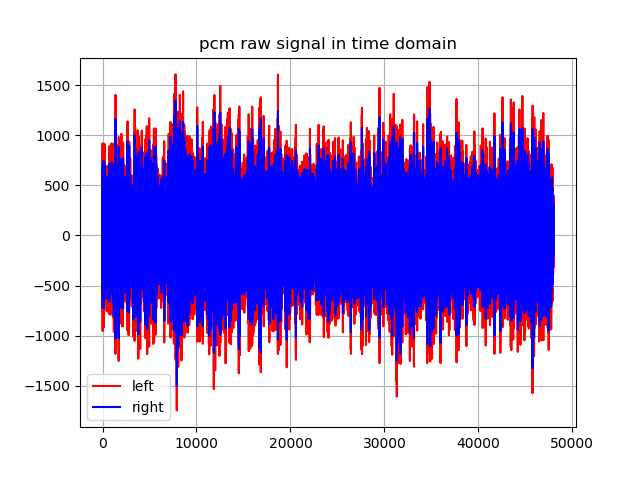

In [63]:
fig = plt.figure()
plt.title("pcm raw signal in time domain")
plt.plot(Right_mic_data, 'r')
plt.plot(Left_mic_data[:], 'b')
plt.legend(('left', 'right'), loc='best')
plt.grid(True)
plt.show()


In [100]:
# Beamforming slot
# read beamformer parameters from .csv file. there is 65 bins
fft_len = 128
fs = 16000
hop = 80
window_length = 128
syn_frames = 3

# load beamforming weights
weights_dspc_2cm = pd.read_csv("./beamforming/weights/weight_2cm.csv", header=None).values.astype(str).astype(np.complex)
weights_dspc_2cm = weights_dspc_2cm.T

freq_leftCh = stft.stft(Left_mic_data)
freq_rightCh = stft.stft(Right_mic_data)
freq_output_beamformed = np.zeros(np.shape(freq_leftCh), dtype=np.complex)
for i in range(np.shape(freq_leftCh)[0]):
    freq_leftCh[i, :] = freq_leftCh[i, :] * weights_dspc_2cm[0, :]
    freq_rightCh[i, :] = freq_rightCh[i, :] * weights_dspc_2cm[1, :]
    freq_output_beamformed[i,:] = freq_leftCh[i, :] + freq_rightCh[i, :]

preprocess_output_woscnr = stft.istft(freq_output_beamformed)

In [101]:
# SCNR slot
# we use spectral-sub method in this slot

scnr_specsub = scnr.SpectralSub(fft_len, db_reduc=10, lookback=3, beta=20, alpha=3)

for n in range(np.shape(freq_output_beamformed)[0]):
    gain_filt = scnr_specsub.compute_gain_filter(freq_output_beamformed[n, :])
    freq_output_beamformed[n, :] = freq_output_beamformed[n, :] * gain_filt[:]


In [102]:
preprocess_output = stft.istft(freq_output_beamformed)
ipd.Audio(data=preprocess_output, rate=16000.)

<IPython.core.display.Javascript object>


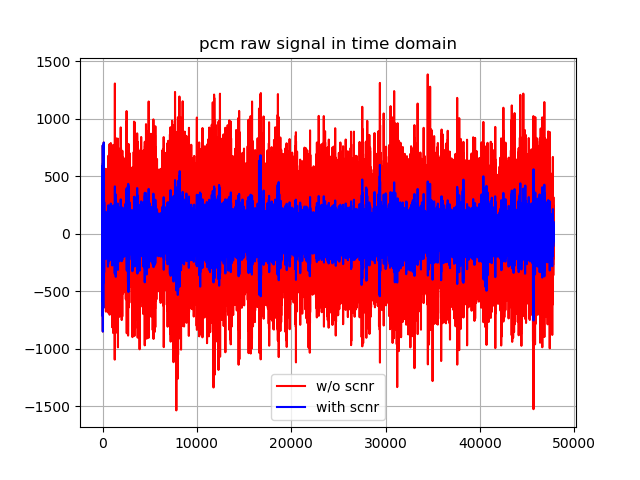

In [103]:
fig = plt.figure()
plt.title("pcm raw signal in time domain")
plt.plot(preprocess_output_woscnr[80:-80], 'r')
plt.plot(preprocess_output[80:-80], 'b')
plt.legend(('w/o scnr', 'with scnr'), loc='best')
plt.grid(True)
plt.show()


In [1]:
a = [0,1,2]
len(a)

3